In [106]:
# 3) Univariate statistics between MS ans MS-TN on the important predictors. 
# Load predictor names from the csv - similar to the plots. 
# Run independent t-test on these features, collect p_vals to the list.
# Correct the list of pvals for the multiple tests ("FDR"). 
# Save output as csv with corrected p, plot the boxplot, with hue being the diagnosis

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import json
import scipy.stats as stats
import statsmodels.stats.multitest as smm
from statsmodels.stats.multitest import fdrcorrection

In [108]:
# load data
ml_dataframe = pd.read_csv("stats/ml_dataframe.csv")
important_features = pd.read_csv("out/important_features.csv")
important_features = important_features.rename(columns={'feature': 'importance'})
important_features = important_features.rename(columns={'Unnamed: 0': 'feature'})

# create separate dataframe with only top features to use for graphing, add diagnosis column based on ml_dataframe
top_features = important_features[important_features['importance'] >= 5]
top_features = top_features['feature'].tolist()
top_features_dataframe = ml_dataframe[top_features]
top_features_dataframe['diagnosis'] = ml_dataframe['diagnosis']
top_features_dataframe = top_features_dataframe.melt(id_vars=['diagnosis'], var_name='feature', value_name='value').fillna(0)
print(top_features_dataframe)

# set up groups for t-test
ms_dataframe = ml_dataframe[ml_dataframe['diagnosis'] == 'MS']
ms_tn_dataframe = ml_dataframe[ml_dataframe['diagnosis'] == 'MS-TN']

     diagnosis                        feature     value
0        MS-TN                         lh_PuI  0.000151
1        MS-TN                         lh_PuI  0.000170
2        MS-TN                         lh_PuI  0.000186
3        MS-TN                         lh_PuI  0.000169
4        MS-TN                         lh_PuI  0.000099
...        ...                            ...       ...
1579        MS  lh_G_temp_sup-Plan_tempo_area  0.397657
1580        MS  lh_G_temp_sup-Plan_tempo_area  0.515600
1581        MS  lh_G_temp_sup-Plan_tempo_area  0.406081
1582        MS  lh_G_temp_sup-Plan_tempo_area  0.437194
1583        MS  lh_G_temp_sup-Plan_tempo_area  0.399095

[1584 rows x 3 columns]


/var/folders/05/4bm5nzbd43d1zy10xs1n6j780000gn/T/ipykernel_51931/1495768903.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_features_dataframe['diagnosis'] = ml_dataframe['diagnosis']


In [109]:
# run t-test
list_of_important_predictors = important_features['feature'].tolist()
print(list_of_important_predictors)

p_vals = []
p_corrected = []
stats_vals = []

for feature in list_of_important_predictors:
    input_ms = ms_dataframe[feature]
    input_ms_tn = ms_tn_dataframe[feature]
    ttest1 = stats.ttest_ind(input_ms, input_ms_tn, equal_var=True, nan_policy="omit", permutations=None, random_state=None, alternative="two-sided", trim=0)
    #nan_policy='propagate' when all data there
    p_vals.append(ttest1.pvalue)
    stats_vals.append(ttest1.statistic)

['lh_PuI', 'lh_VPL', 'lh_G_oc-temp_med-Lingual_thickness', 'lh_G_insular_short_area', 'rh_CA3-body', 'lh_fimbria', 'rh_G&S_transv_frontopol_area', 'rh_S_collat_transv_post_thickness', 'rh_G_front_middle_area', 'lh_G_rectus_area', 'lh_G_temporal_inf_area', 'lh_G_temp_sup-Plan_tempo_area', 'rh_S_orbital_lateral_thickness', 'rh_L-Sg', 'rh_S_occipital_ant_thickness', 'lh_G_temp_sup-Lateral_area', 'lh_S_orbital-H_Shaped_thickness', 'lh_G&S_occipital_inf_area', 'lh_G_temp_sup-Plan_polar_area', 'lh_G_pariet_inf-Supramar_area', 'rh_Pf', 'lh_G_cingul-Post-dorsal_area', 'lh_WhiteSurfArea_area', 'rh_CA3-head', 'rh_VLa', 'lh_HATA', 'rh_MDm', 'lh_G_oc-temp_lat-fusifor_area', 'lh_Lat_Fis-ant-Vertical_area', 'rh_S_oc-temp_med&Lingual_area', 'lh_MDl', 'rh_S_orbital-H_Shaped_area', 'rh_VM', 'lh_S_pericallosal_area', 'rh_Medial-nucleus', 'rh_S_front_sup_area', 'lh_VLp', 'rh_G_oc-temp_med-Lingual_area', 'rh_Pole_temporal_area', 'rh_S_front_middle_area', 'lh_PuM', 'rh_PuM', 'lh_G_postcentral_area', 'rh_G_

In [110]:
# correct p-values for multiple tests

rejected_pval, p_corrected = fdrcorrection(p_vals, alpha=0.05, method='indep')
# replace rejected p-values with "NS"

for i in range(len(p_corrected)):
    if rejected_pval[i] == False:
        p_corrected[i] = 1
    else:
        p_corrected[i] = p_corrected[i]

In [111]:
# save as csv
features_pvalues = pd.DataFrame(list(zip(list_of_important_predictors, p_corrected)), columns =['predictor', 'p_corrected'])
features_pvalues.to_csv('stats/features_pvalues.csv', index=False)
features_pvalues['p_corrected'] = ['NS' if features_pvalues==1 else '*' if features_pvalues>0.01 else '**' if features_pvalues>0.0001 else '***' for features_pvalues in features_pvalues['p_corrected']]
print(features_pvalues)

                             predictor p_corrected
0                               lh_PuI          NS
1                               lh_VPL         ***
2   lh_G_oc-temp_med-Lingual_thickness         ***
3              lh_G_insular_short_area           *
4                          rh_CA3-body         ***
5                           lh_fimbria          NS
6         rh_G&S_transv_frontopol_area          NS
7    rh_S_collat_transv_post_thickness         ***
8               rh_G_front_middle_area          NS
9                     lh_G_rectus_area          NS
10              lh_G_temporal_inf_area          NS
11       lh_G_temp_sup-Plan_tempo_area          NS
12      rh_S_orbital_lateral_thickness          NS
13                             rh_L-Sg          NS
14        rh_S_occipital_ant_thickness          **
15          lh_G_temp_sup-Lateral_area          **
16     lh_S_orbital-H_Shaped_thickness          NS
17           lh_G&S_occipital_inf_area          NS
18       lh_G_temp_sup-Plan_pol

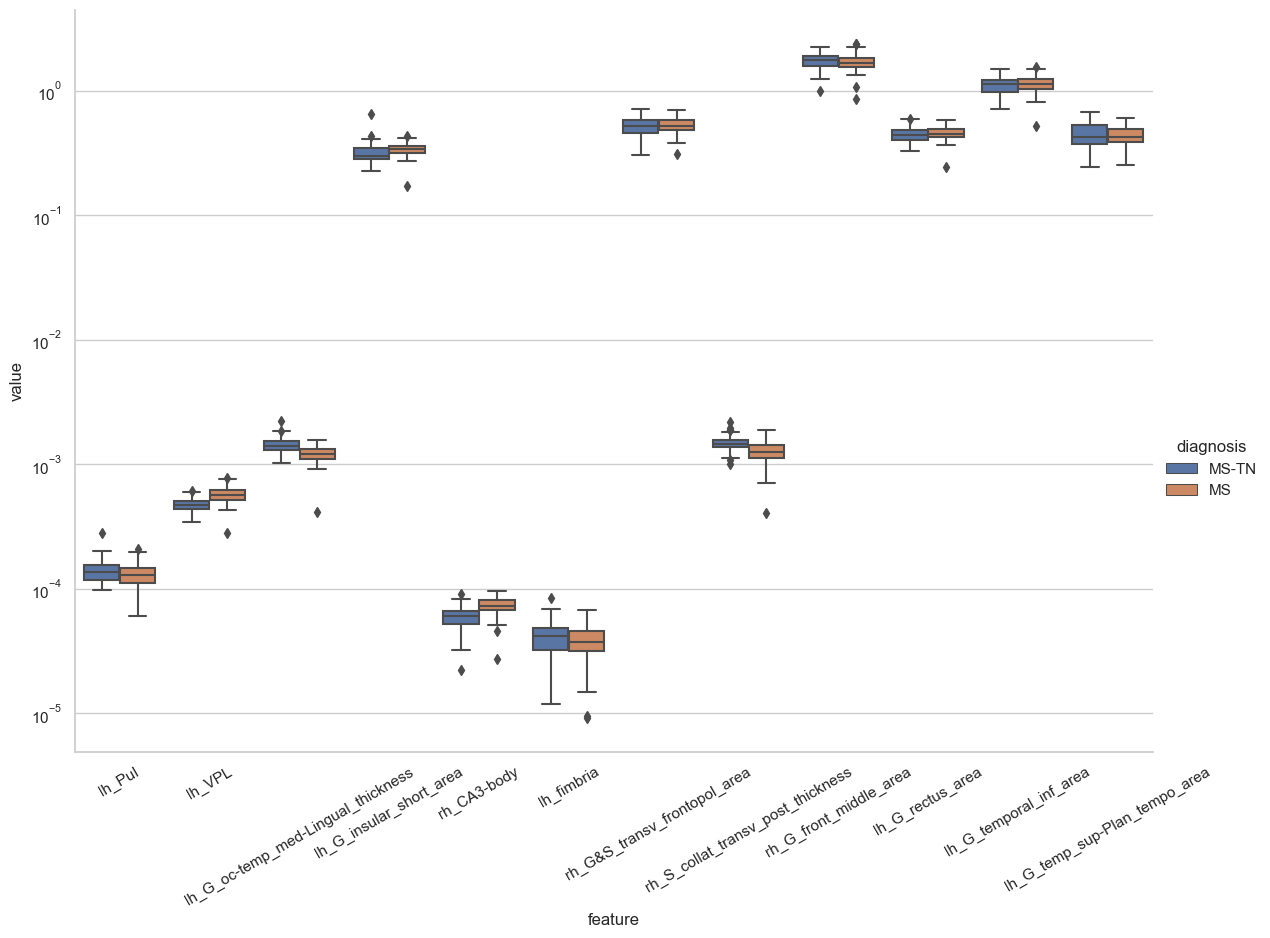

In [112]:
# plotting the values of the top predictors

sns.catplot(data=top_features_dataframe, kind="box", x="feature", y="value", hue="diagnosis", height=8.27, aspect=11.7/8.27)
plt.xticks(rotation=30)
plt.yscale('log')
plt.show()